## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration points using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [83]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = '../camera_cal/cornersfound/corners_found'+str(images.index(fname))+'.jpg'
        cv2.imwrite(write_name, img)

### Use the object points and image points to calibrate and undistort the camera

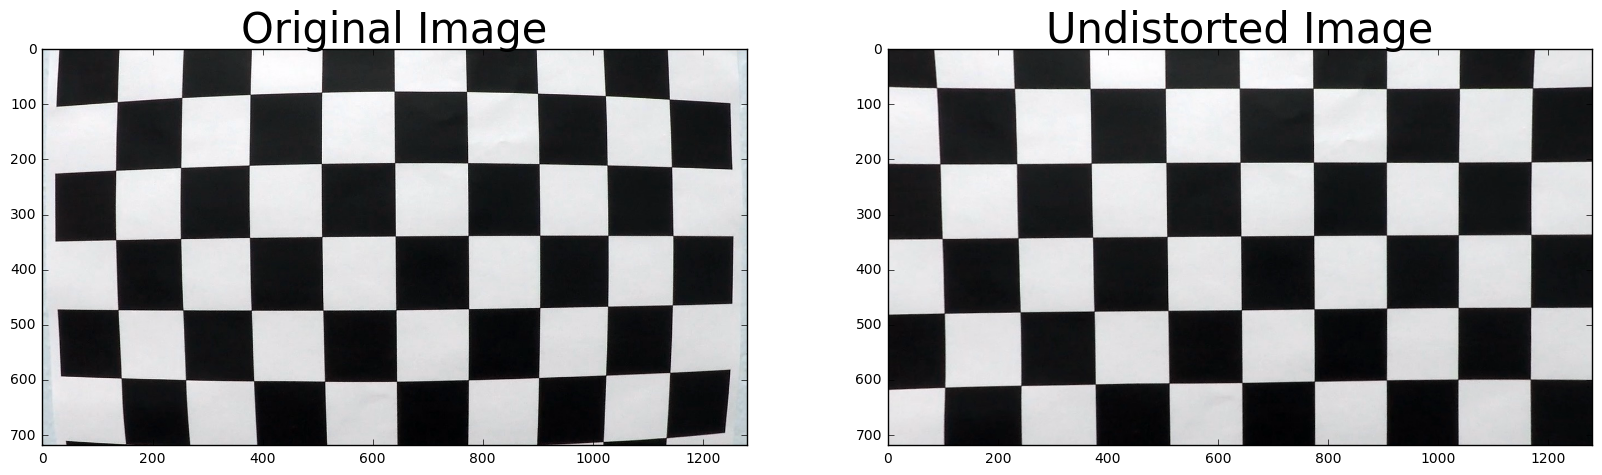

In [84]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


undist = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

## Use the image of a straight road to kickstart the process

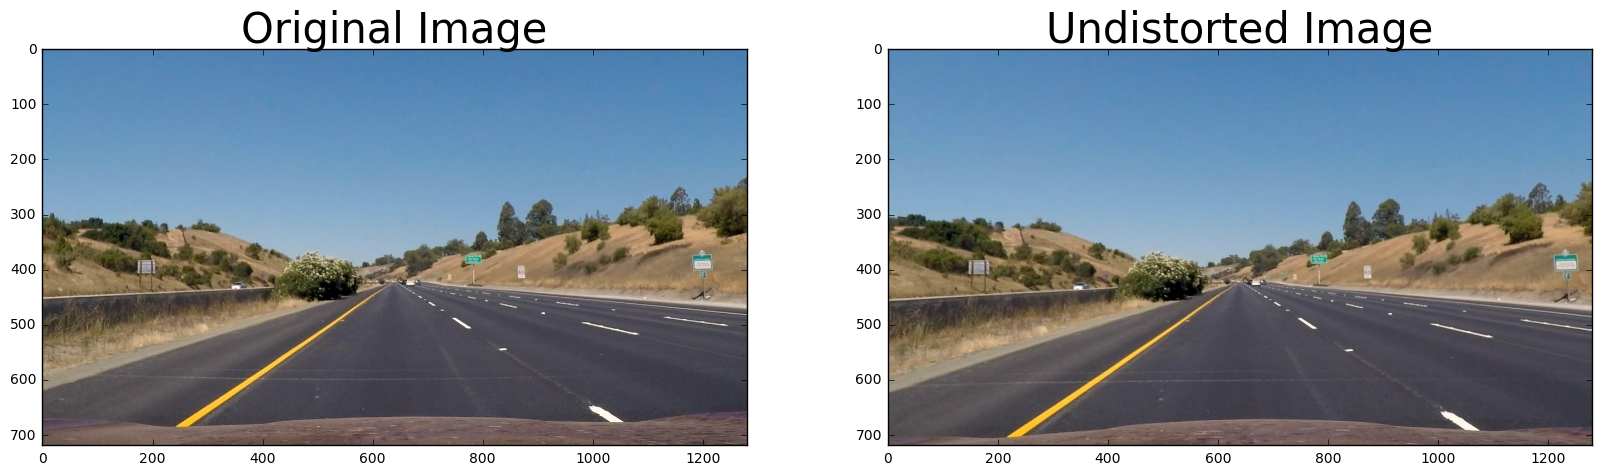

In [102]:
import pickle
%matplotlib inline
dist_pickle = pickle.load( open( "../camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

img = cv2.imread('../test_images/straight_lines1.jpg')
img = img[...,::-1] # rotate back to rgb
img_size = (img.shape[1], img.shape[0])
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

In [87]:
import example as e

img = np.copy(img)
# Convert to HSV color space and separate the V channel
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
red = img[:,:,0]
print("dimensions:")
print("hls", hls.shape)
print("l_channel", l_channel.shape)
print("s_channel", s_channel.shape)
print("gray", gray.shape)
print("red", red.shape)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
mag_binary = e.mag_thresh(gray, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = e.dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
red_gradx = e.abs_sobel_thresh(red, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grey_gradx = e.abs_sobel_thresh(red, orient='x', sobel_kernel=ksize, thresh=(20, 100))

s_thresh=(170, 255)
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

print("dimensions of threshs:")
print("mag_binary", mag_binary.shape)
print("dir_binary", dir_binary.shape)
print("red_gradx", red_gradx.shape)
print("grey_gradx", grey_gradx.shape)
print("s_binary", s_binary.shape)

dimensions:
hls (720, 1280, 3)
l_channel (720, 1280)
s_channel (720, 1280)
gray (720, 1280)
red (720, 1280)
dimensions of threshs:
mag_binary (720, 1280)
dir_binary (720, 1280)
red_gradx (720, 1280)
grey_gradx (720, 1280)
s_binary (720, 1280)


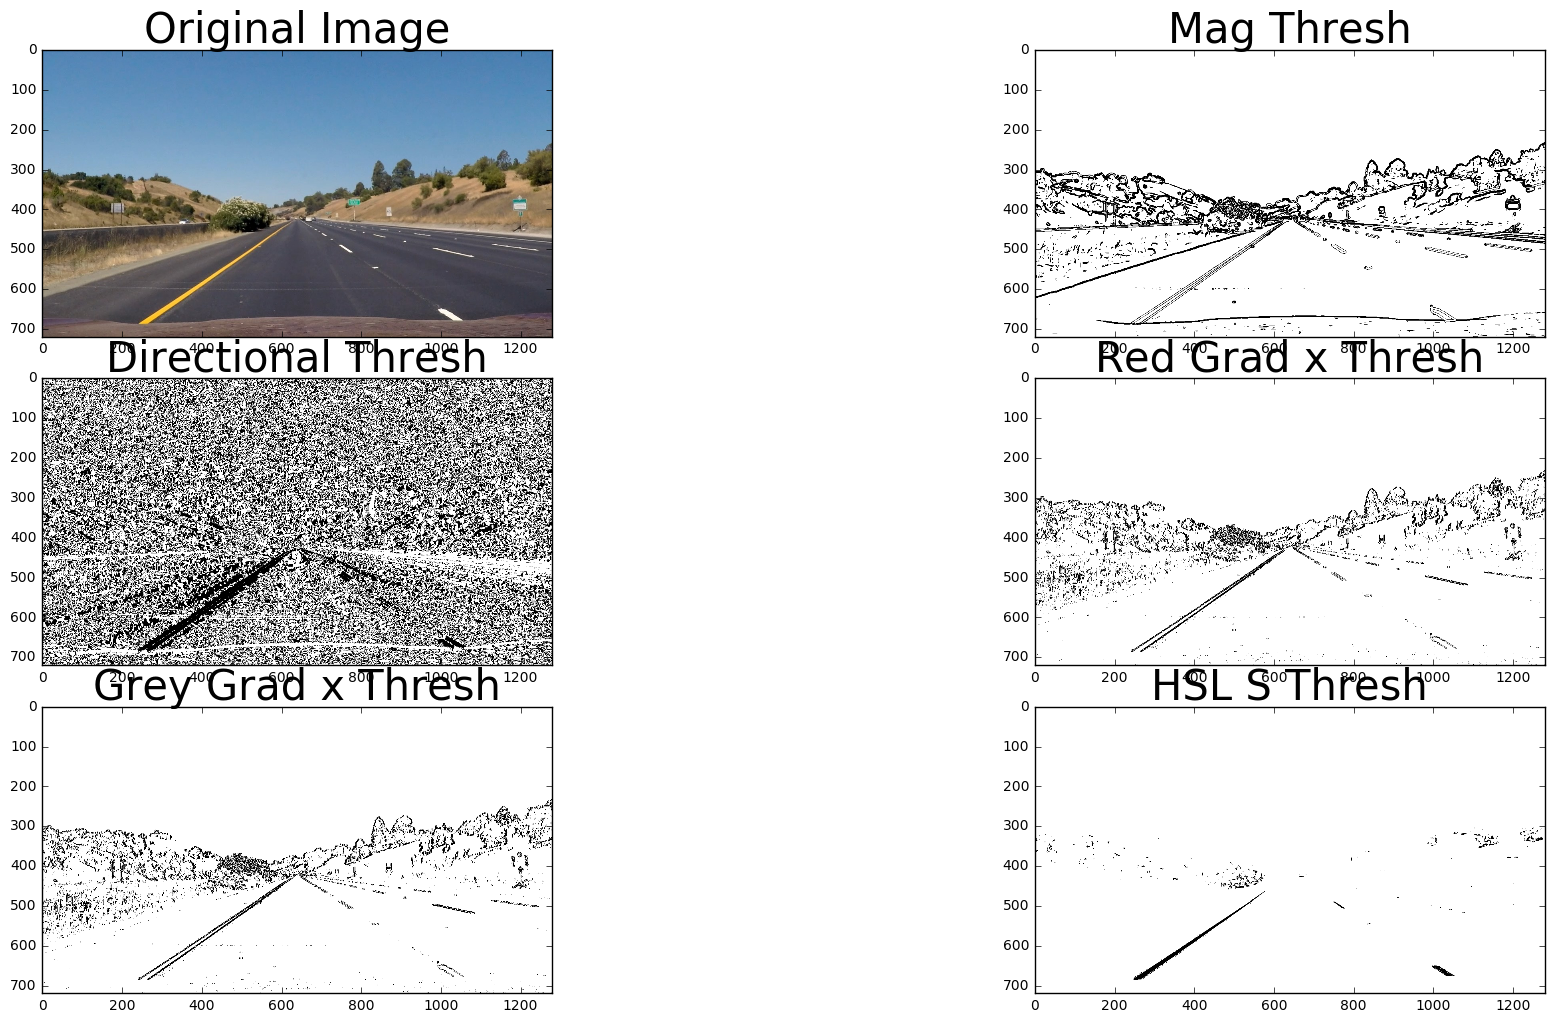

In [89]:
%matplotlib inline
f, axarr = plt.subplots(3, 2, figsize=(20,10))
f.tight_layout()
axarr[0, 0].imshow(img)
axarr[0, 0].set_title('Original Image', fontsize=30)

axarr[0, 1].imshow(mag_binary, cmap='Greys')
axarr[0, 1].set_title('Mag Thresh', fontsize=30)

axarr[1, 0].imshow(dir_binary, cmap='Greys')
axarr[1, 0].set_title('Directional Thresh', fontsize=30)

axarr[1, 1].imshow(red_gradx, cmap='Greys')
axarr[1, 1].set_title('Red Grad x Thresh', fontsize=30)

axarr[2, 0].imshow(grey_gradx, cmap='Greys')
axarr[2, 0].set_title('Grey Grad x Thresh', fontsize=30)

axarr[2, 1].imshow(s_binary, cmap='Greys')
axarr[2, 1].set_title('HSL S Thresh', fontsize=30)

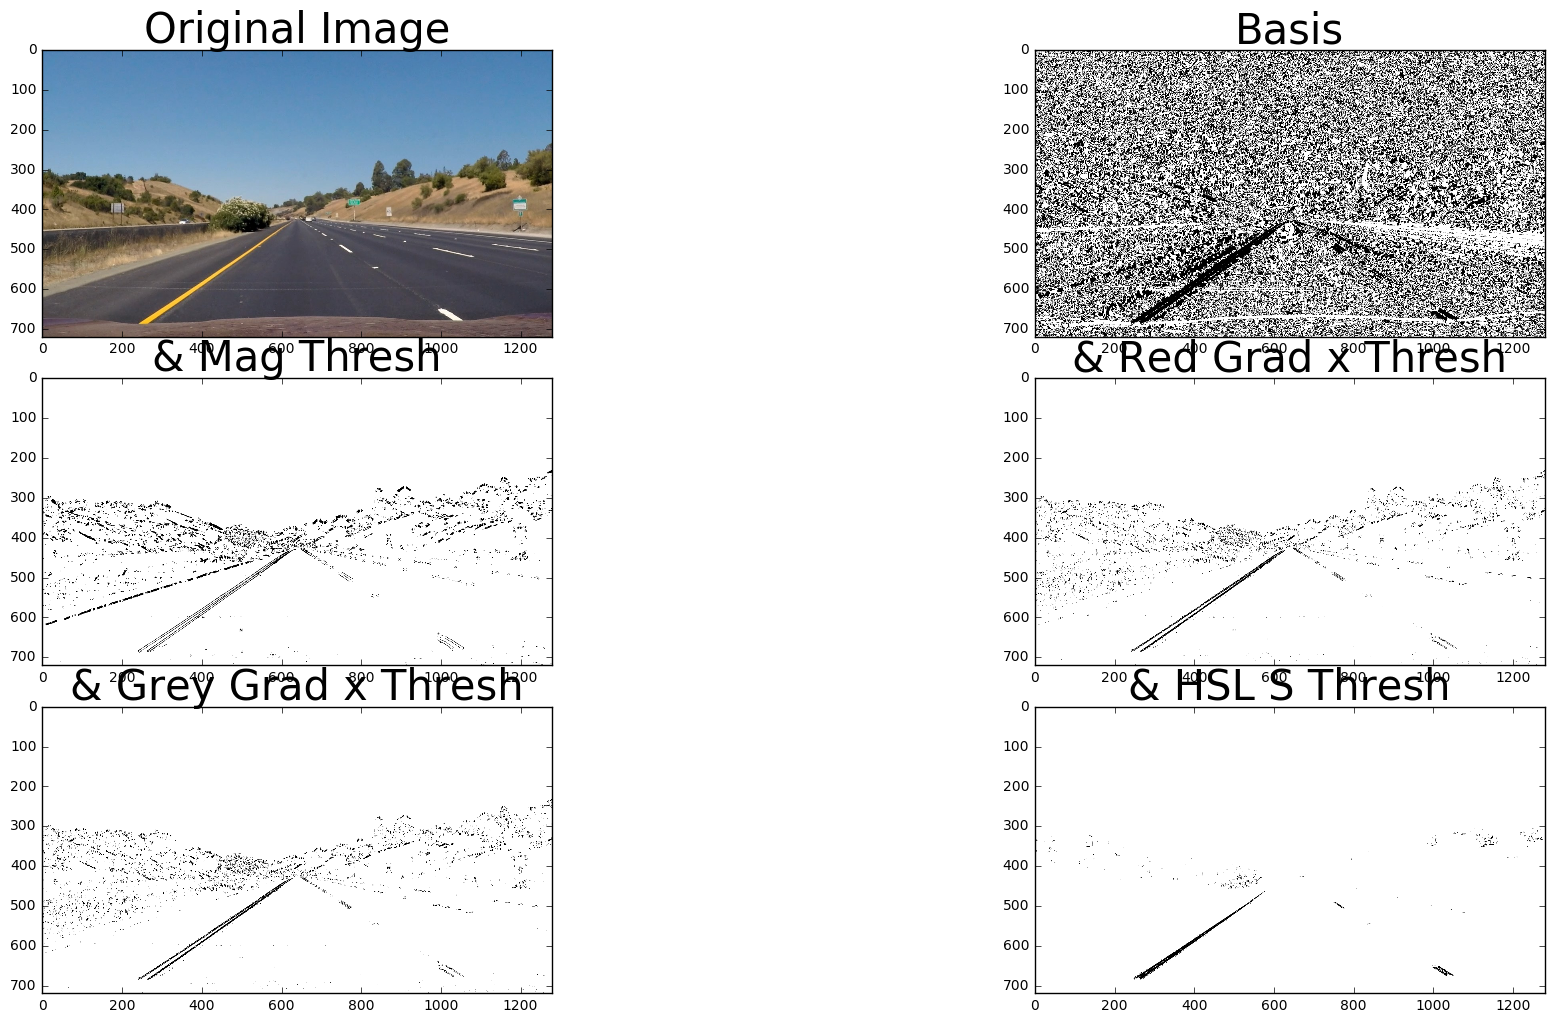

In [90]:
dir_mag = np.zeros_like(dir_binary)
dir_mag[(dir_binary == 1) & (mag_binary == 1)] = 1

redx_mag = np.zeros_like(dir_binary)
redx_mag[(dir_binary == 1) & (red_gradx == 1)] = 1

greyx_mag = np.zeros_like(dir_binary)
greyx_mag[(dir_binary == 1) & (grey_gradx == 1)] = 1

sbin_mag = np.zeros_like(dir_binary)
sbin_mag[(dir_binary == 1) & (s_binary == 1)] = 1


%matplotlib inline
f, axarr = plt.subplots(3, 2, figsize=(20,10))
f.tight_layout()
axarr[0, 0].imshow(img)
axarr[0, 0].set_title('Original Image', fontsize=30)

axarr[0, 1].imshow(dir_binary, cmap='Greys')
axarr[0, 1].set_title('Basis', fontsize=30)

axarr[1, 0].imshow(dir_mag, cmap='Greys')
axarr[1, 0].set_title('& Mag Thresh', fontsize=30)

axarr[1, 1].imshow(redx_mag, cmap='Greys')
axarr[1, 1].set_title('& Red Grad x Thresh', fontsize=30)

axarr[2, 0].imshow(greyx_mag, cmap='Greys')
axarr[2, 0].set_title('& Grey Grad x Thresh', fontsize=30)

axarr[2, 1].imshow(sbin_mag, cmap='Greys')
axarr[2, 1].set_title('& HSL S Thresh', fontsize=30)

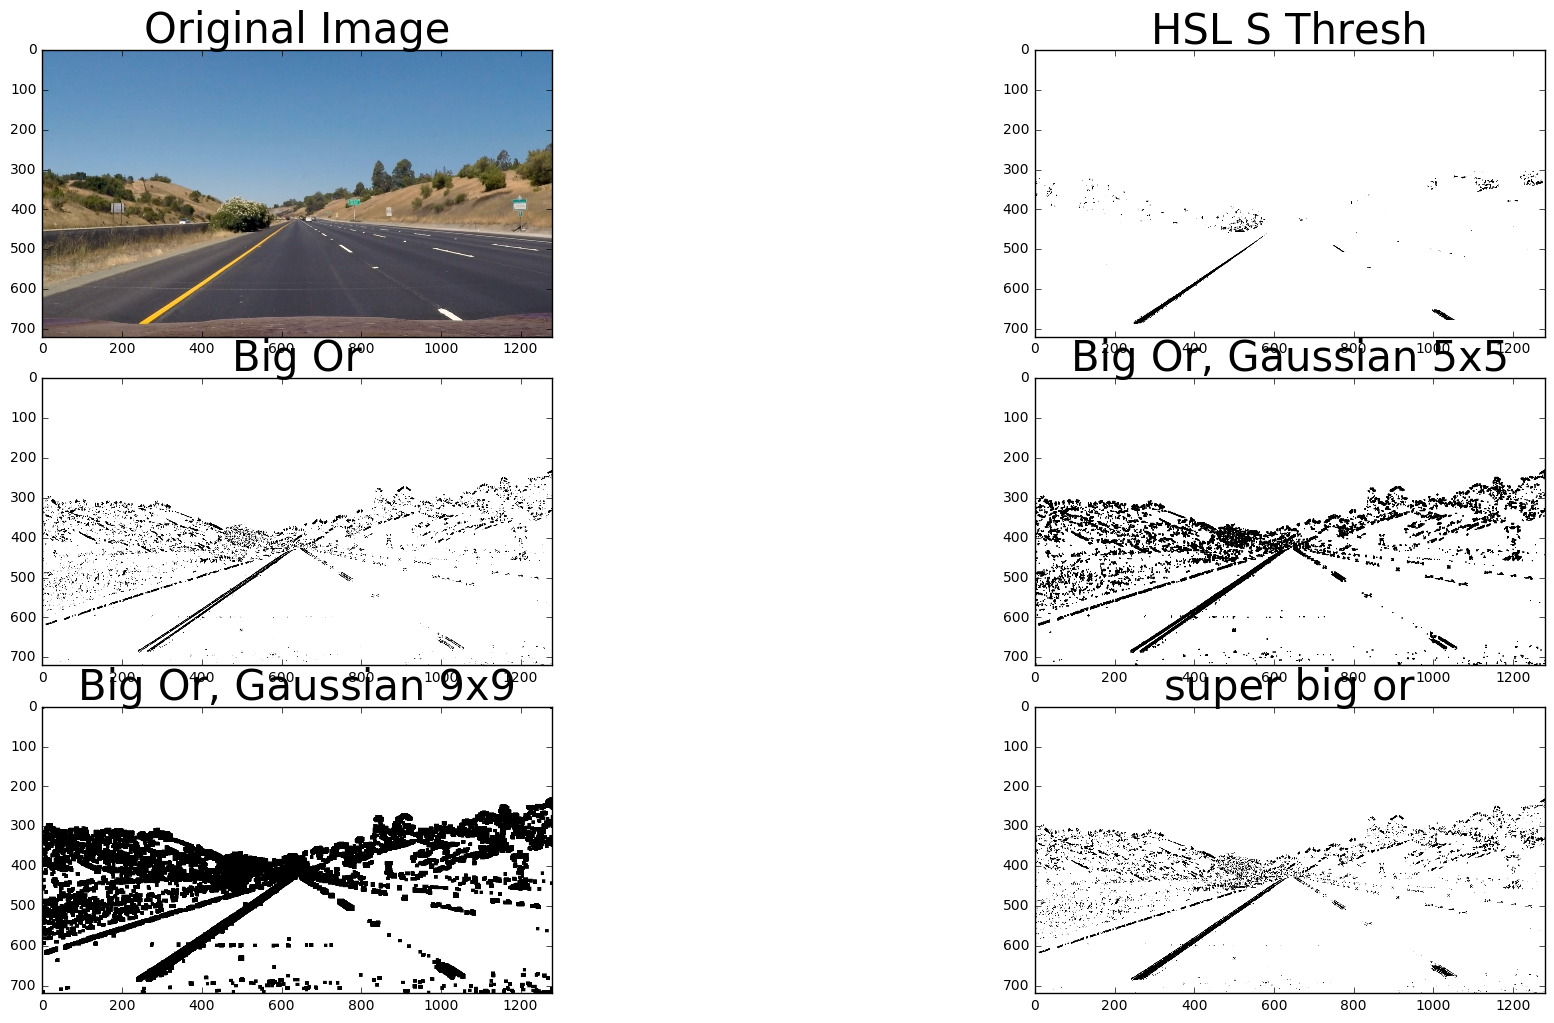

In [91]:
big_or = np.zeros_like(dir_binary)
big_or[(redx_mag == 1) | (greyx_mag == 1) | (dir_mag == 1)] = 1

big_or_g1_tmp = cv2.GaussianBlur(big_or,(3,3),0)
big_or_g1 = np.zeros_like(dir_binary)
big_or_g1[big_or_g1_tmp > 0] = 1

big_or_g2_tmp = cv2.GaussianBlur(big_or,(9,9),0)
big_or_g2 = np.zeros_like(dir_binary)
big_or_g2[big_or_g2_tmp > 0] = 1

big_or_and_s = np.zeros_like(dir_binary)
big_or_and_s[(big_or == 1) | (s_binary == 1)] = 1


%matplotlib inline
f, axarr = plt.subplots(3, 2, figsize=(20,10))
f.tight_layout()
axarr[0, 0].imshow(img, cmap='Greys')
axarr[0, 0].set_title('Original Image', fontsize=30)

axarr[0, 1].imshow(s_binary, cmap='Greys')
axarr[0, 1].set_title('HSL S Thresh', fontsize=30)

axarr[1, 0].imshow(big_or, cmap='Greys')
axarr[1, 0].set_title('Big Or', fontsize=30)

axarr[1, 1].imshow(big_or_g1, cmap='Greys')
axarr[1, 1].set_title('Big Or, Gaussian 5x5', fontsize=30)

axarr[2, 0].imshow(big_or_g2, cmap='Greys')
axarr[2, 0].set_title('Big Or, Gaussian 9x9', fontsize=30)

axarr[2, 1].imshow(big_or_and_s, cmap='Greys')
axarr[2, 1].set_title('super big or', fontsize=30)

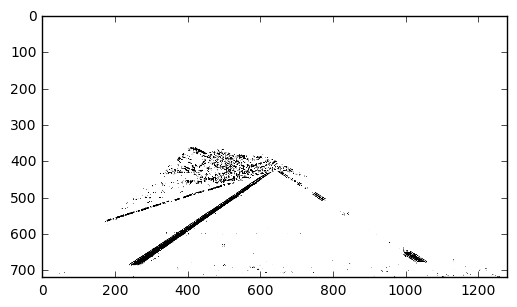

In [92]:
%matplotlib inline
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# like in P1 we can mask the image for an region of interest:
vertices = np.array([[(0,big_or_and_s.shape[0]),(450, 325), (490, 325), (big_or_and_s.shape[1],big_or_and_s.shape[0])]], dtype=np.int32)
img_masked = region_of_interest(big_or_and_s, vertices)
plt.imshow(img_masked, cmap='Greys')


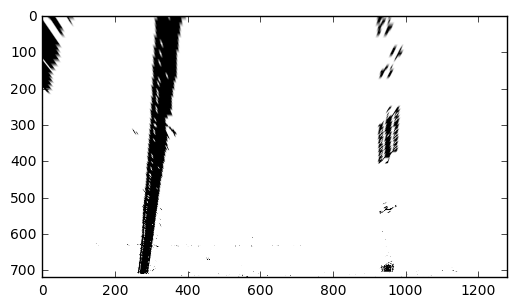

In [93]:
#src = np.float32([
#    (190, 720),
#    (470, 466),
#    (640, 466),
#    (1100, 720)])
src = np.float32([
    (132, 703),
    (540, 466),
    (720, 466),
    (1147, 703)])

dst = np.float32([
    (200, 720),
    (200, 0),
    (1000, 0),
    (1000, 720)])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(big_or_and_s, M, big_or_and_s.shape[::-1], flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='Greys')

# this images is not perfectily in the middle, so if they are paralell but a little bit off, that is fine

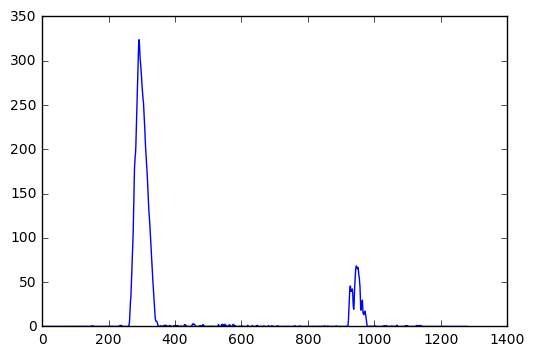

In [94]:
import numpy as np
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [95]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

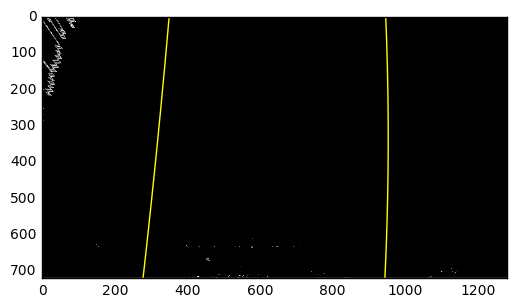

In [96]:
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [97]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

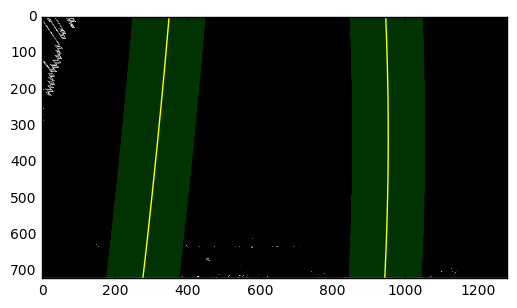

In [98]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [99]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

24854.2961566 7946.99502591


In [100]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
left_fit_cr = np.polyfit(ym_per_pix*lefty, xm_per_pix*leftx, 2)
right_fit_cr = np.polyfit(ym_per_pix*righty, xm_per_pix*rightx, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

8006.65357725 m 2600.96121788 m


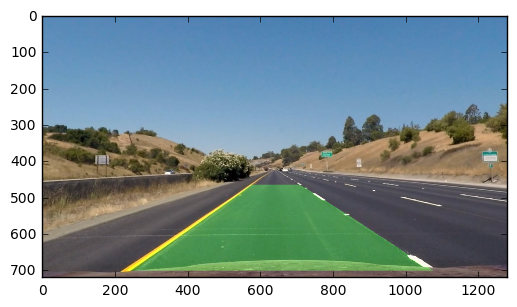

In [103]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)